In [48]:

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

training_df = pd.read_csv("data/train.csv")
prediction_df = pd.read_csv("data/predict.csv")
TARGET_COLUMN = "zeta_disease"


#Data Processing
#get height
def height_from_bmi(row):
    
    if row["bmi"] <= 0 or row["weight"] <= 0:
        return np.nan
    height_in_inches = ((row["weight"] * 703.0) / row["bmi"]) ** 0.5
    return height_in_inches / 12  # Convert inches to feet


training_df["height"] = training_df.apply(height_from_bmi, axis=1)
prediction_df["height"] = training_df.apply(height_from_bmi, axis=1)

#age limit: 95
#height limit: 4ft - 6.5ft
training_df = training_df[
    (training_df["age"].le(95)) & 
    (training_df["height"].between(4.0, 6.5, inclusive='both')) &
    (training_df["height"].notna())
]



def clean_and_impute_zeros(df, columns_to_clean):
    """
    Replace zeros with NaN in specified columns, drop rows with >1 NaN,
    and impute remaining NaNs with median.
    
    Args:
        df (pd.DataFrame): Input dataframe
        columns_to_clean (list): Columns to check for zeros
        
    Returns:
        pd.DataFrame: Cleaned dataframe
    """
    # Step 1: Replace 0 with NaN in target columns
    df[columns_to_clean] = df[columns_to_clean].replace(0, np.nan)
    
    # Step 2: Drop rows with >1 NaN (across all columns)
    df = df.dropna(thresh=len(df.columns) - 1)  # Keep rows missing ≤1 value
    
    # Step 3: Impute remaining NaNs with median
    imputer = SimpleImputer(strategy='median')
    df[columns_to_clean] = imputer.fit_transform(df[columns_to_clean])
    
    return df

# Example usage:
columns_to_clean = [
    'weight', 
    'bmi', 
    'blood_pressure', 
    'insulin_test', 
    'cardio_stress_test', 
    'liver_stress_test'
]

training_df = clean_and_impute_zeros(training_df, columns_to_clean)

#split data
X = training_df.drop(TARGET_COLUMN, axis=1)
y = training_df[TARGET_COLUMN]

training_df

/var/folders/m4/t_rq12813b3gjxfxfq7_t3c00000gn/T/ipykernel_32259/2126078120.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_clean] = imputer.fit_transform(df[columns_to_clean])


,age,weight,bmi,blood_pressure,insulin_test,cardio_stress_test,liver_stress_test,years_smoking,zeta_disease,height
1,23,150.0,38.5,68.0,71.0,55.0,0.3868,2,0,4.361257
3,18,150.0,30.8,70.0,1033.0,56.0,0.6598,0,0,4.876034
4,24,160.0,32.4,74.0,125.0,59.0,0.7608,2,0,4.910027
6,20,154.0,27.8,64.0,116.0,53.0,0.5168,0,0,5.200372
7,37,167.0,34.5,88.0,145.0,54.0,0.4658,1,1,4.861218
...,...,...,...,...,...,...,...,...,...,...
491,59,247.0,34.7,70.0,132.0,129.0,0.6378,2,1,5.894950
492,26,196.0,38.2,76.0,194.0,65.0,0.3918,2,0,5.004870
494,37,173.0,33.1,70.0,94.0,74.0,0.4368,9,0,5.051327
496,25,162.0,38.4,86.0,160.0,72.0,0.3088,2,0,4.538249


In [49]:

from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Preprocessing pipeline
# scale numerical features
numeric_features = ["age","weight","bmi","blood_pressure","insulin_test","liver_stress_test","cardio_stress_test","years_smoking","height"]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Create and train the classifier pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'weight', 'bmi',
                                                   'blood_pressure',
                                                   'insulin_test',
                                                   'liver_stress_test',
                                                   'cardio_stress_test',
                                                   'years_smoking',
                                                   'height'])])),
                ('classifier', GradientBoostingClassifier())])

## Evaluation

In [51]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        19
           1       0.85      0.79      0.81        14

    accuracy                           0.85        33
   macro avg       0.85      0.84      0.84        33
weighted avg       0.85      0.85      0.85        33



## Data Analysis

In [52]:
#average height training/predicted
#percentage training over 6.5
#average human height per wikipedia (no country dataset has an average less than 5'1")
#https://en.wikipedia.org/wiki/Average_human_height_by_country#Second_table:_estimated_average_height_of_19-year-olds_in_2019

#train normal distribution

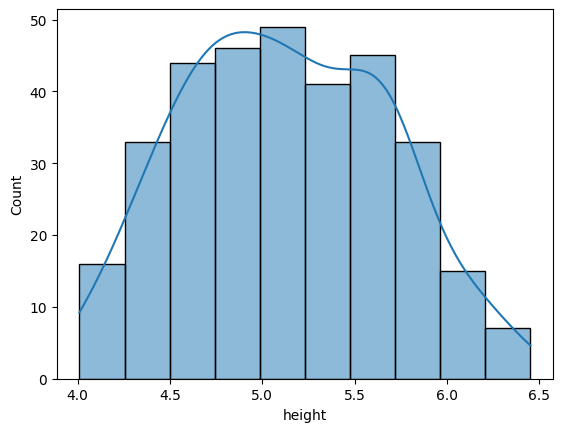

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram + KDE
sns.histplot(data=training_df, x='height', kde=True)
plt.show()

